In [130]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import os, sys
import scipy.io
import gsw

In [131]:
#exp_name = "sinusoidal-slope_rotating_stratified_no-mixing"
exp_name = "sinusoidal-slope_rotating_stratified_mixing"

input_path = f"../../../MITgcm/experiments/BLT_test_{exp_name}/input/"
print(input_path)
if ~os.path.exists("/".join(input_path.split("/")[0:-2])):
    os.system(f"mkdir -p {input_path}")

../../../MITgcm/experiments/BLT_test_sinusoidal-slope_rotating_stratified_mixing/input/


In [132]:
# Release location
dye_loc = [-11.885, 54.21]

## Physical parameters

In [133]:
# environmental parameters
ω = 2.*np.pi/(12.*3600.)

ϕdye = np.deg2rad(dye_loc[1])
f = 4*np.pi/86400.*np.sin(ϕdye)
f = np.round(f/ω*24.)*ω/24
print(f"f = {f}")

# grid param
nx = 192
ny = 80
nz = 450

dx = 100
dy = 100
dz0 = 4.
dzmax = 100.
nz_vary_frac = 0.75

Lx = nx*dx
Ly = ny*dy
print(f"Lx = {Lx*1e-3}, Ly = {Ly*1e-3}")

k0 = 5.2e-5

f = 0.0001151432492635148
Lx = 19.2, Ly = 8.0


#### Vertical grid

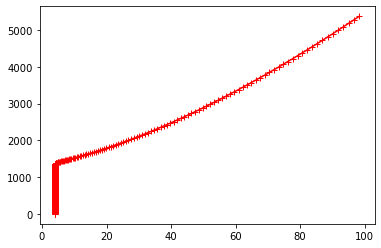

In [134]:
nz_vary = np.int64(nz*nz_vary_frac)
dz = dz0 * np.ones((nz))[:,np.newaxis,np.newaxis]*np.ones((nz,ny,nx))
dz[nz_vary:,:,:] = dz0 + (dzmax-dz0)*(np.arange(0,nz-nz_vary,1.0)[:,np.newaxis,np.newaxis]/(nz-nz_vary))**2
#dz[nz_vary:,:,:] = dz[nz_vary,0,0]*np.arange(0,nz-nz_vary,1.0)[:,np.newaxis,np.newaxis]*np.ones((nz-nz_vary,ny,nx))
Hz = sum(dz[:,0,0])

plt.figure()
plt.plot(dz[:,0,0],np.cumsum(dz[:,0,0]),"r-+")

In [135]:
x = np.arange(dx/2., Lx, dx)
y = np.arange(dy/2., Ly, dy)

In [136]:
slopeAngle = 0.058817189569051985
h = 20.
n = 5
Hbot = h*(np.sin(n*2*np.pi*x/Lx)+1.) - Hz + dz0/2
Hbot = np.tile(Hbot, (ny, 1))

In [137]:
g = 9.81
α = 0.00014117963593745456
gamma = 0.001444072277246354
N = np.sqrt(α*g*gamma)

In [138]:
U0res = 0.1
U0 = U0res*((ω**2 - f**2 - N**2*np.sin(slopeAngle)**2) / ω**2)
ϕ = 0.

In [139]:
U = np.zeros((nz, ny, nx)) - U0res*f/ω*np.sin(ϕ)
V = np.zeros((nz, ny, nx)) + U0res*f/ω*np.cos(ϕ)

In [140]:
T = np.zeros((nz, ny, nx)) + U0res/(α*g)*(N**2*np.sin(slopeAngle)/ω)*np.cos(ϕ)
T_rand = np.tile(np.random.normal(size=(ny, nx),scale=1.e-9)/(g*α), (nz, 1, 1))
#T += T_rand 

R = np.copy(T)

In [141]:
Z = np.cumsum(dz[:, 0, 0][::-1])[::-1]

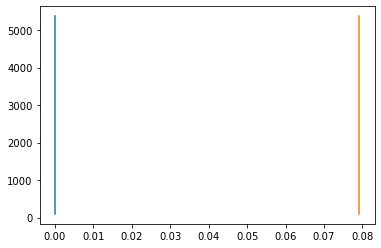

In [142]:
plt.plot(np.mean(U, axis=(1,2)), Z)
plt.plot(np.mean(V, axis=(1,2)), Z)

In [143]:
K = np.zeros((nz,ny,nx)) + k0

In [144]:
tauSponge = 1./3600.
tauSponge

0.0002777777777777778

<ipython-input-145-c3867f80ddf4>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x, y, Hbot)


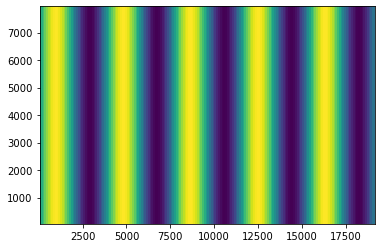

In [145]:
plt.pcolor(x, y, Hbot)

#### Write init files

In [146]:
# Reverse vertical axis so first index is at the surface and transpose axes
U = U[::-1,:,:]
V = V[::-1,:,:]
T = T[::-1,:,:]
R = R[::-1,:1,:1]
K = K[::-1,:,:]

dz = dz[::-1,:1,:1]

# save input data as binary files
newFile = open(input_path+"U.init", "wb")
newFile.write(bytes(U.astype('>f8')))
newFile.close()

newFile = open(input_path+"V.init", "wb")
newFile.write(bytes(V.astype('>f8')))
newFile.close()

newFile = open(input_path+"T.init", "wb")
newFile.write(bytes(T.astype('>f8')))
newFile.close()

np.savetxt(input_path+"R.init", R[:,0,0], encoding="-ascii", fmt='%.7e', newline="\n   ")

newFile = open(input_path+"kappa.init", "wb")
newFile.write(bytes(K.astype('>f8')))
newFile.close()

newFile = open(input_path+"topog.init", "wb")
newFile.write(bytes(Hbot[:,:].astype('>f8')))
newFile.close()

newFile = open(input_path+"delZ.init", "wb")
newFile.write(bytes(dz[:,0,0].astype('>f8')))
newFile.close()

#### Final input parameter values

In [147]:
print(f"Internal wave regime:\nf {round(f, 5)} 1/s << ω = {round(ω, 5)} 1/s << N = {round(np.sqrt(g*α*gamma), 5)} 1/s")
print("")
print(f"α = {α} (ºC)^-1$")
print(f"f = {f} rad/s")
print("")
print(f"θ = {slopeAngle}")
print(f"Γ = {str(gamma)} ºC/m")
print(f"ϕ = {ϕ} rad")
print(f"ω = {ω} rad/s")
print(f"U0 = {str(U0)} m/s")
print("")
print(f"Ur = {str(U0res)} m/s")
print("")
print(f"Advective CLF condition constraint:\nΔt < Δz/U0 = {dz0/U0res} seconds")

Internal wave regime:
f 0.00012 1/s << ω = 0.00015 1/s << N = 0.00141 1/s

α = 0.00014117963593745456 (ºC)^-1$
f = 0.0001151432492635148 rad/s

θ = 0.058817189569051985
Γ = 0.001444072277246354 ºC/m
ϕ = 0.0 rad
ω = 0.0001454441043328608 rad/s
U0 = 0.004656667977711338 m/s

Ur = 0.1 m/s

Advective CLF condition constraint:
Δt < Δz/U0 = 40.0 seconds


In [148]:
import os
os.system(f"cp ./genBLT_{exp_name}.ipynb {input_path}");